In [1]:
!pip install tensorflow opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 69.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.1 MB/s eta 0:00:00


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications import ResNet50



In [29]:
def ensure_3_channels(image, label):
    if image.shape.ndims == 2:
        image = tf.expand_dims(image, axis=-1)
        image = tf.repeat(image, repeats=3, axis=-1)
    return image, label

In [24]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

In [25]:
IMG_SIZE = 128
BATCH_SIZE = 32

def preprocess(image,label):
  image = tf.image.resize(image,(IMG_SIZE,IMG_SIZE))
  image = tf.cast(image,tf.float32)/255.0
  return image,label


In [26]:
ds_train = ds_train.map(preprocess).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [27]:
def dataset_to_numpy(dataset):
    images, labels = [], []
    for image, label in dataset.unbatch():
        images.append(image.numpy())
        labels.append(label.numpy())
    return images, labels

In [33]:
x_train, y_train = dataset_to_numpy(ds_train)
x_test, y_test = dataset_to_numpy(ds_test)
x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train).reshape(-1)
y_test = np.array(y_test).reshape(-1)

In [30]:
#model 1 : CNN
models = Sequential([
    Conv2D(32,(3,3),activation='relu',input_shape=(128,128,3)),
    MaxPooling2D((2,2)),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128,activation='relu'),
    Dense(1,activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [31]:
models.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])


In [34]:
history = models.fit(x_train,y_train,epochs=5,validation_data=(x_test,y_test))


Epoch 1/5
581/581 ━━━━━━━━━━━━━━━━━━━━ 474s 812ms/step - accuracy: 0.6111 - loss: 0.6362 - val_accuracy: 0.7634 - val_loss: 0.4877
Epoch 2/5
581/581 ━━━━━━━━━━━━━━━━━━━━ 456s 784ms/step - accuracy: 0.7706 - loss: 0.4752 - val_accuracy: 0.7985 - val_loss: 0.4280
Epoch 3/5
581/581 ━━━━━━━━━━━━━━━━━━━━ 454s 781ms/step - accuracy: 0.8271 - loss: 0.3875 - val_accuracy: 0.8267 - val_loss: 0.3805
Epoch 4/5
581/581 ━━━━━━━━━━━━━━━━━━━━ 456s 785ms/step - accuracy: 0.8635 - loss: 0.3118 - val_accuracy: 0.8381 - val_loss: 0.3592
Epoch 5/5
581/581 ━━━━━━━━━━━━━━━━━━━━ 455s 783ms/step - accuracy: 0.9095 - loss: 0.2248 - val_accuracy: 0.8409 - val_loss: 0.4156


In [35]:
y_pred = models.predict(x_test)
y_pred1 = (y_pred > 0.5).astype("int32").flatten()
acc = np.mean(y_pred1 == y_test)
print(f"accuracy by manual method: {acc * 100:.2f} %\n")
print(f"accuracy by tf : {models.evaluate(x_test,y_test)[1]*100} % \n")
print(f"loss by tf : {models.evaluate(x_test,y_test)[0]*100} % \n")
print(f"classification report : {classification_report(y_pred1,y_test,target_names=['Cat', 'Dog'])}")


145/145 ━━━━━━━━━━━━━━━━━━━━ 27s 183ms/step
accuracy by manual method: 84.09 %

145/145 ━━━━━━━━━━━━━━━━━━━━ 27s 188ms/step - accuracy: 0.8391 - loss: 0.4228
accuracy by tf : 84.09482836723328 % 

145/145 ━━━━━━━━━━━━━━━━━━━━ 27s 185ms/step - accuracy: 0.8391 - loss: 0.4228
loss by tf : 41.56336188316345 % 

classification report :               precision    recall  f1-score   support

         Cat       0.87      0.82      0.84      2434
         Dog       0.81      0.87      0.84      2206

    accuracy                           0.84      4640
   macro avg       0.84      0.84      0.84      4640
weighted avg       0.84      0.84      0.84      4640



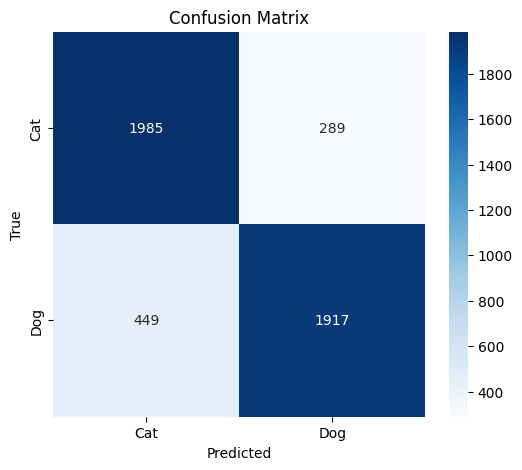

In [36]:
cm = confusion_matrix(y_test, y_pred1)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


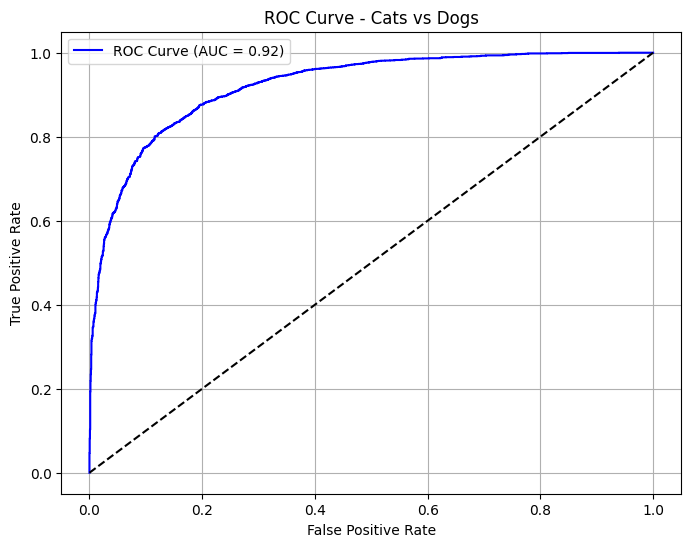

In [37]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve - Cats vs Dogs')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


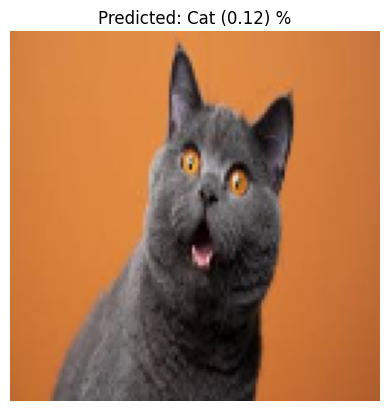

'Cat'

In [38]:
def predict_cat_dog(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print("Image not found.")
        return -1

    img = cv2.resize(img, (128, 128))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_array = img_rgb / 255.0
    img_array = img_array.reshape(1, 128, 128, 3)
    pred = models.predict(img_array)[0][0]
    label = "Dog" if pred >= 0.5 else "Cat"
    plt.imshow(img_rgb)
    plt.title(f"Predicted: {label} ({pred*100:.2f}) %")
    plt.axis('off')
    plt.show()

    return label
predict_cat_dog("/content/download.jpg")